In [1]:
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import kneighbors_graph
from sklearn.decomposition import PCA
from harmonypy import run_harmony

import matplotlib.pyplot as plt
from anndata import AnnData
import pandas as pd
import numpy as np
import seaborn as sns
import colorcet as cc
import scanpy as sc
import igraph as ig
import colorcet as cc
import leidenalg
import umap
import copy
import os

from functions import map_scatter, glasbey, leiden_cluster

In [2]:
# read in cleaned data
data_path = os.path.join('..', 'outputs', 'clean.csv')

if os.path.exists(data_path):
    df = pd.read_csv(data_path)
else:
    print(f"File not found: {data_path}.\nCheck data path.")

In [3]:
metadata = ['Image', 'Object ID', 'Classification', 'Parent', 'Centroid X µm', 'Centroid Y µm']
markers = [col for col in df.columns if col not in metadata]
print(markers)

['DAPI', 'CD44', 'HLA-DR', 'CD4', 'IFNG', 'Ki67', 'CD107a', 'CD45', 'CD20', 'CD40', 'CD8', 'Pan-Cytokeratin', 'CD68', 'HLA-A', 'CD79a', 'CD45RO', 'CD21', 'CD11c', 'HLA-E', 'IDO1', 'CD14', 'CD56', 'VISTA', 'FOXP3', 'Granzyme B', 'PCNA', 'T-bet/TBX21', 'PD-L1', 'TOX', 'PD-1', 'CD38', 'ICOS', 'CD39', 'LAG3', 'TCF-1', 'CD3e']


### Dimensionality reduction
UMAP and PCA

In [6]:
# run PCA
pca = PCA(n_components=10)
pca_red = pca.fit_transform(df[markers])
# make pca df
pca_df = pd.DataFrame(pca_red, columns=['PC1_1', 'PC2_1', 'PC3_1', 'PC4_1', 'PC5_1', 'PC6_1', 'PC7_1', 'PC8_1', 'PC9_1', 'PC10_1'])

In [7]:
# get explained variance ratio for each principal component
explained_variance_ratio = pca.explained_variance_ratio_

# print the variance for each PC
for i, variance in enumerate(explained_variance_ratio, start=1):
    print(f"Principal Component {i}: {variance:.4f} variance explained")

Principal Component 1: 0.3514 variance explained
Principal Component 2: 0.0920 variance explained


Text(0.5, 1.0, 'PCA of All Data')

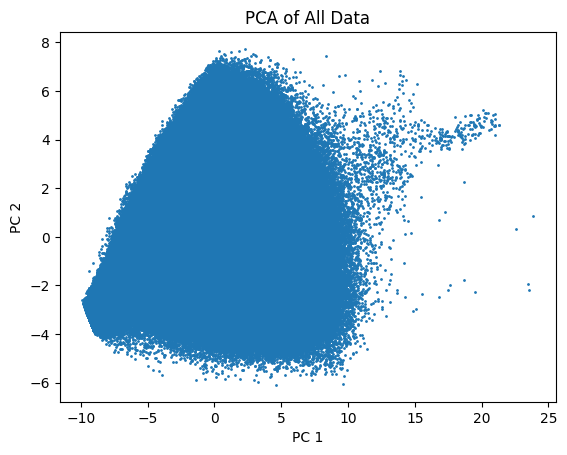

In [8]:
# plot PCA result
plt.scatter(pca_red[:, 0], pca_red[:, 1], s=1)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('PCA of All Data')

In [4]:
# run UMAP
umap_red = umap.UMAP(
    n_components=2,
    n_neighbors=10,
    metric="correlation",
    random_state=42,
    min_dist=0.1
)
umap_emb = umap_red.fit_transform(pca_red)
# make umap df
umap_df = pd.DataFrame(umap_emb, columns=["UMAP1", "UMAP2"])

c:\Users\16472\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Text(0, 0.5, 'UMAP 2')

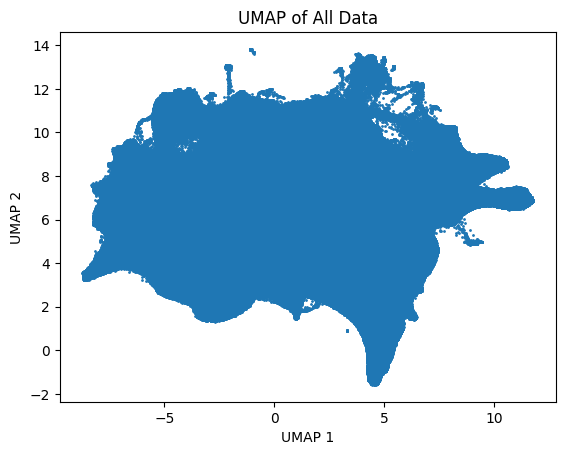

In [5]:
# plot UMAP result
plt.scatter(umap_emb[:, 0], umap_emb[:, 1], s=1)
plt.title('UMAP of All Data')
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")

In [9]:
df = pd.concat([df.reset_index(drop=True), umap_df.reset_index(drop=True), pca_df.reset_index(drop=True)], axis=1)
df.head()

,Image,Object ID,Classification,Parent,Centroid X µm,Centroid Y µm,DAPI,CD44,HLA-DR,CD4,IFNG,Ki67,CD107a,CD45,CD20,CD40,CD8,Pan-Cytokeratin,CD68,HLA-A,CD79a,CD45RO,CD21,CD11c,HLA-E,IDO1,CD14,CD56,VISTA,FOXP3,Granzyme B,PCNA,T-bet/TBX21,PD-L1,TOX,PD-1,CD38,ICOS,CD39,LAG3,TCF-1,CD3e,UMAP1,UMAP2,PC1,PC2
0,Slide10_Scan1.ome.tif,f5505ea9-ddff-4fea-90dd-a425402a544d,Other/NA,Slide 10 C1-1,4004.2,1674.9,-0.443124,-1.278166,-0.611227,-0.836912,-0.373927,-0.558038,-0.945680,-1.209588,-0.918000,-1.275033,-0.479002,-0.964177,-1.734488,-1.600974,-1.069471,-0.735331,-0.599537,-0.606381,-0.967712,-0.456628,1.406843,-0.059258,-0.837762,-0.975134,-0.155099,-2.008079,0.569947,-1.092399,-0.512276,-0.536722,-0.767958,-0.900027,-0.530450,-1.661986,-1.439516,-0.895539,6.738408,6.757998,-5.286668,-0.298409
1,Slide10_Scan1.ome.tif,4b313e44-f97c-43e8-99a7-31b9ab2a45c0,Other/NA,Slide 10 C1-1,4055.9,1675.2,-1.365461,-1.426814,-0.966250,-1.498882,-0.371016,-0.574953,-1.215879,-1.270394,-0.914412,-1.254947,-0.479002,-0.751162,-1.310785,-1.909365,-1.064014,-1.000205,-0.599537,-0.610082,-0.967712,-0.362557,-0.633839,-0.394380,-0.837762,-0.979127,-0.155099,-2.059527,0.438516,-1.100433,-0.512276,-0.531385,-0.767958,-0.945659,-0.530450,-1.541051,-1.406103,-1.080230,7.695970,6.541201,-5.876908,-0.926938
2,Slide10_Scan1.ome.tif,e0673808-3a80-4490-b565-2fa9b3425738,CD56,Slide 10 C1-1,4070.8,1675.8,-0.981877,-1.412553,-0.762933,-1.413784,-0.371379,-0.328444,-0.847251,-1.270394,-0.841680,-1.123630,-0.477111,-0.656329,-0.640773,-1.810232,-0.800213,-0.961251,-0.548471,-0.583552,-0.967712,-0.400649,-0.365438,1.413665,-0.833820,-0.956325,-0.144567,-1.158425,0.398702,-1.019284,-0.509256,-0.503575,-0.763376,-0.841767,-0.503103,-1.088439,-0.997410,-1.053522,7.024744,7.164611,-4.714929,-0.376258
3,Slide10_Scan1.ome.tif,e2036b6c-b8ba-42fc-b05c-1e0c8c853192,Other/NA,Slide 10 C1-1,3904.7,1677.1,-0.554083,-1.372611,0.236735,-0.793350,-0.373927,-0.560446,0.220115,-1.209318,-0.921513,-1.156137,-0.479002,-0.936634,-0.463112,-1.264736,-1.076497,-0.853892,-0.599537,-0.610082,-0.964876,-0.455278,0.748997,-0.048217,-0.836047,-0.935414,-0.155099,-1.775034,0.503248,0.066361,-0.512276,-0.473942,-0.766839,-0.938628,-0.462030,-1.421700,-1.354550,-1.077320,6.188785,6.723613,-4.541659,0.661836
4,Slide10_Scan1.ome.tif,5afebba8-c97a-4d69-b9e2-395d49cebd90,Other/NA,Slide 10 C1-1,3921.0,1676.8,-0.943903,-1.384704,-0.198105,-1.196011,-0.373927,-0.563259,-0.336016,-1.265708,-0.915756,-1.160688,-0.479002,-0.924379,-1.111282,-1.117391,-1.066810,-0.915404,-0.599537,-0.610082,-0.967712,-0.459198,0.141778,-0.936240,-0.837762,-0.972407,-0.155099,-1.067197,0.525127,-1.100433,-0.512276,-0.536722,-0.767958,-0.817616,-0.530450,-1.534252,-1.337009,-1.067024,6.777853,6.659214,-5.077836,-0.181445


Plot marker intensity on top of UMAP, PCA

In [18]:
metadata.extend['UMAP1', 'UMAP2', 'PC1_1', 'PC2_1', 'PC3_1', 'PC4_1', 'PC5_1', 'PC6_1', 'PC7_1', 'PC8_1', 'PC9_1', 'PC10_1']
print(metadata)

['Image', 'Object ID', 'Classification', 'Parent', 'Centroid X µm', 'Centroid Y µm', 'UMAP1', 'UMAP2', 'PC1', 'PC2']


In [ ]:
# melt the dataframe so that all markers are in one column called 'Intensity' 
melted = df.melt(id_vars=metadata, var_name="Marker", value_name="Intensity")
melted.head()

In [ ]:
# plot heatmap of each marker on top of the UMAP
f = sns.FacetGrid(melted, col="Marker", col_wrap=5)
f = f.map_dataframe(
    map_scatter, "UMAP1", "UMAP2", "Intensity", s=1, cmap="viridis", vmin=0
)

In [ ]:
# plot heatmap of each marker on top of the PCA
f = sns.FacetGrid(melted, col="Marker", col_wrap=5)
f = f.map_dataframe(
    map_scatter, "PC1_1", "PC2_1", "Intensity", s=1, cmap="viridis", vmin=0
)

### Clustering
Run clustering algorithm (Leiden for now) on UMAP (will run on PCA later).


### Further analysis
- bar chart of proportional change in markers from pre and post slides
- try plot similar to figure 1

In [5]:
umap_emb = df[['UMAP1', 'UMAP2']].values

In [6]:
# leiden clustering on UMAP
clstr_umap = leiden_cluster(umap_emb, res=0.7)
# add to dataframe
df['Cluster_UMAP'] = clstr_umap

In [7]:
# sp = os.path.join('..', 'outputs', 'dimred_clstr.csv')
# df.to_csv(sp, index=False)

### Batch effect correction
Using Harmony. Note that this only changes the PCs, so it basically doesn't matter as we will not be doing unsupervised clustering.

In [ ]:
harmony_object = run_harmony(pca_red, df[metadata], vars_use = 'Parent')

In [ ]:
harmonized_pcs = pd.DataFrame(harmony_object.Z_corr.T, columns=['PC1_hcorr', 'PC2_hcorr', 'PC3_hcorr', 'PC4_hcorr', 'PC5_hcorr', 'PC6_hcorr', 'PC7_hcorr', 'PC8_hcorr', 'PC9_hcorr', 'PC10_hcorr'])
df = pd.concat([df.reset_index(drop=True), harmonized_pcs.reset_index(drop=True)], axis=1) # add to main df

In [ ]:
# plot PC1 and PC2 with sample on top
f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(
    x='PC1_hcorr',
    y='PC2_hcorr',
    hue='Parent',
    legend='full',
    palette=glasbey(int(df['Parent'].nunique())),
    data=df,
    ax=ax,
    s=3
)
plt.title('Sample over PCA (Harmonized)')
plt.legend(ncols=3, markerscale=5)

In [ ]:
# run UMAP on PCs after harmony batch correction and plot
umap_results2 = umap_red.fit_transform(harmony_object.Z_corr.T)
umap_harmonized = pd.DataFrame(umap_results2, columns=['UMAP1_hcorr', 'UMAP2_hcorr'])
df = pd.concat([df.reset_index(drop=True), umap_harmonized.reset_index(drop=True)], axis=1) # add to main df

# plot sample on top of UMAP
f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(
    x='UMAP1_hcorr',
    y='UMAP2_hcorr',
    hue='Sample',
    legend='full',
    palette=glasbey(int(df['Parent'].nunique())),
    data=df,
    ax=ax,
    s=3
)
plt.title('UMAP from PCs (Harmonized)')
plt.legend(ncols=3, markerscale=5)

In [ ]:
sp = os.path.join('..', 'outputs', 'bln_harmonized.csv')
df.to_csv(sp, index=False)

In [ ]:
# # plot clusters on top of the UMAP
# f, ax = plt.subplots(figsize=(12, 12))

# sns.scatterplot(
#     x="UMAP1",
#     y="UMAP2",
#     hue="Cluster_UMAP",
#     legend="full",
#     palette=glasbey(int(df['Cluster_UMAP'].nunique())),
#     data=df,
#     ax=ax,
#     s=3
# )
# plt.legend(loc='lower left', ncols=4, markerscale=4)

In [ ]:
# metadata.append('Cluster_UMAP')
# print(metadata)

In [ ]:
# # dot plot of the clusters and the markers present
# X = df[markers].values  # marker data as numpy array
# obs = df[metadata].copy()     # metadata as a dataframe

# # can use Cluster, Patient, etc. here
# obs['Cluster_UMAP'] = obs['Cluster_UMAP'].astype('category')

# adata = AnnData(X=X, obs=obs)

# adata.var_names = markers
# adata.var = pd.DataFrame(index=markers)

# # make the dotplot
# sc.pl.dotplot(adata, 
#               var_names=markers,   # The list of markers to show on the x-axis
#               groupby='Cluster_UMAP',
#               title='Marker proportions in each cluster (from UMAP)'
#               ) 

In [ ]:
# # dot plot of lymph node and the markers present
# X = df[markers].values  # marker data as numpy array
# obs = df[metadata].copy()     # metadata as a dataframe

# # can use Cluster, Patient, etc. here
# obs['Parent'] = obs['Parent'].astype('category')

# adata = AnnData(X=X, obs=obs)

# adata.var_names = markers
# adata.var = pd.DataFrame(index=markers)

# # make the dotplot
# sc.pl.dotplot(adata, 
#               var_names=markers,   # The list of markers to show on the x-axis
#               groupby='Parent',
#               title='Marker proportions in each lymph node'
#               ) 

In [ ]:
# # for each lymph node, plot cluster on top of the xy coordinates
# grouped = df.groupby('Parent')
# for name, group in grouped:
#     # plot the xy coordinates 
#     f, ax = plt.subplots(figsize=(10, 10))

#     sns.scatterplot(
#         x="Centroid X µm", 
#         y="Centroid Y µm",
#         hue="Cluster",
#         legend="full",
#         palette="rainbow",
#         data=group,
#         ax=ax,
#         s=10
#     ).set(title=f'Lymph node {name} xy plot')

#     sns.despine()
#     ax.legend(bbox_to_anchor=(1.05, 1), loc=2, markerscale=1, borderaxespad=0.)
#     plt.show()

In [ ]:
# # for each lymph node, plot classification on top of the xy coordinates
# grouped = df.groupby('Parent')
# for name, group in grouped:
#     # plot the xy coordinates 
#     f, ax = plt.subplots(figsize=(10, 10))

#     sns.scatterplot(
#         x="Centroid X µm", 
#         y="Centroid Y µm",
#         hue="Classification",
#         legend="full",
#         palette="rainbow",
#         data=group,
#         ax=ax,
#         s=10
#     ).set(title=f'Lymph node {name} xy plot')

#     sns.despine()
#     ax.legend(bbox_to_anchor=(1.05, 1), loc=2, markerscale=1, borderaxespad=0.)
#     plt.show()

In [ ]:
# heatmap of markers and lymph nodes, can see diff between pre and post
# melt data
# df_long = pd.melt(df, id_vars=['Parent'], value_vars=markers, var_name='Marker', value_name='Intensity')


# plt.figure(figsize=(10, 8))
# sns.heatmap(df_long.pivot_table(index='Parent', columns='Marker', values='Intensity', aggfunc='mean'), cmap='coolwarm')
# plt.xlabel('Markers')
# plt.ylabel('Lymph Node')
# plt.title('Heatmap of Marker Intensities Grouped by Lymph Node')
# plt.show()

In [ ]:
# for ln in df['Parent'].unique():
#     bln_patient_df = df[df['Parent'] == patient]
#     srg_patient_df = surgery[surgery['Patient'] == patient]
    
#     # calculate proportions for baseline
#     ncells_patient_baseline = len(bln_patient_df)
#     marker_counts_baseline = bln_patient_df[markers].sum()
#     prop_wrt_patient_baseline = marker_counts_baseline / ncells_patient_baseline
    
#     # calculate proportions for surgery
#     ncells_patient_surgery = len(srg_patient_df)
#     marker_counts_surgery = srg_patient_df[markers].sum()
#     prop_wrt_patient_surgery = marker_counts_surgery / ncells_patient_surgery
    
#     # settings for graph
#     bar_width = 0.35
#     index = np.arange(len(markers))
    
#     plt.figure(figsize=(12, 6))
    
#     # bar plot for baseline
#     plt.bar(index, prop_wrt_patient_baseline, bar_width, label='Baseline')
    
#     # bar plot for surgery
#     plt.bar(index + bar_width, prop_wrt_patient_surgery, bar_width, label='Surgery')
    
#     plt.xlabel('Markers')
#     plt.ylabel('# cells pos / # cells with Patient ID')
#     plt.title(f'Proportional counts for each marker for Patient {patient} at baseline and surgery')
#     plt.xticks(index + bar_width / 2, markers, rotation=45)
#     plt.ylim([0, 1])
#     plt.legend()
    
#     plt.tight_layout()
#     plt.show()